# Correct for the technical variation added

The goal of this notebook is to try to correct for the technical variation that was added by each experiment

The approach is to,
1. Import the simulated data representing varying experiments
2. Use [removeBatchEffect](https://rdrr.io/bioc/limma/man/removeBatchEffect.html) package from the limma library in R.
3. Calculate the similarity between the dataset with a single experiment and the dataset corrected for the variation introduced by having some number of experiments added.

In [12]:
%load_ext autoreload
%autoreload 2
%load_ext rpy2.ipython

import rpy2
from rpy2.robjects.packages import importr
from rpy2.robjects import pandas2ri
limma = importr('limma')

import os
import sys
import glob
import pandas as pd
from plotnine import ggplot, ggtitle, xlab, ylab, geom_point, geom_line, aes, ggsave
import warnings
warnings.filterwarnings(action='ignore')

sys.path.append("../")
from functions import generate_data
from functions import similarity_metric

from numpy.random import seed
randomState = 123
seed(randomState)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [2]:
%%R
# Run once to install needed R packages
#install.packages(c("devtools"))
#source("http://www.bioconductor.org/biocLite.R")
#biocLite(c("limma"))
library(limma)

In [3]:
# User parameters
NN_architecture = 'NN_2500_30'
analysis_name = 'analysis_0'
num_simulated_samples = 6000
lst_num_experiments = [1,2,5,10,20,50,100,500,1000,2000,3000,6000]
use_pca = True
num_PCs = 10

In [4]:
# Input files
base_dir = os.path.abspath(os.path.join(os.getcwd(),"../.."))    # base dir on repo
local_dir = "/home/alexandra/Documents/"                         # base dir on local machine for data storage

# Simulated data file 
simulated_data_file = os.path.join(
    local_dir,
    "Data",
    "Batch_effects",
    "simulated",
    analysis_name,
    "simulated_data.txt.xz")

In [5]:
# Output file
svcca_file = os.path.join(
    local_dir,
    "Data",
    "Batch_effects",
    "output",
    "svcca_correction.pdf")

### Correct for added variation

In [6]:
for i in lst_num_experiments:
    print('Correcting for {} experiments..'.format(i))

    # Simulated data with experiments added
    experiment_file = os.path.join(
        local_dir,
        "Data",
        "Batch_effects",
        "experiment_simulated",
        analysis_name,
        "Experiment_" + str(i) + ".txt.xz")
    
    # Read in data
    # data transposed to form gene x sample for R package
    experiment_data = pd.read_table(
        experiment_file,
        header=0,
        index_col=0,
        sep='\t').T
    
    # Experimental ids
    experiment_map_file = os.path.join(
        local_dir,
        "Data",
        "Batch_effects",
        "experiment_simulated",
        analysis_name,
        "Experiment_map_" + str(i) + ".txt.xz")
    
    # Read in map
    experiment_map = pd.read_table(
        experiment_map_file,
        header=0,
        index_col=0,
        sep='\t')['experiment']
    
    if i == 1:
        corrected_experiment_data_df = experiment_data.copy()
    
    else:    
        # Correct for technical variation
        corrected_experiment_data = limma.removeBatchEffect(experiment_data, batch=experiment_map)

        # Convert R object to pandas df
        corrected_experiment_data_df = pandas2ri.ri2py_dataframe(corrected_experiment_data)
    
    # Write out corrected files
    experiment_corrected_file = os.path.join(
        local_dir,
        "Data",
        "Batch_effects",
        "experiment_simulated",
        analysis_name,
        "Experiment_corrected_" + str(i) + ".txt.xz")
    
    corrected_experiment_data_df.to_csv(
        experiment_corrected_file, float_format='%.3f', sep='\t', compression='xz')

Correcting for 1 experiments..
Correcting for 2 experiments..
Correcting for 5 experiments..
Correcting for 10 experiments..
Correcting for 20 experiments..
Correcting for 50 experiments..
Correcting for 100 experiments..
Correcting for 500 experiments..
Correcting for 1000 experiments..
Correcting for 2000 experiments..
Correcting for 3000 experiments..
Correcting for 6000 experiments..


### Calculate similarity

In [7]:
# Permuted simulated data file 
permuted_simulated_data_file = os.path.join(
    local_dir,
    "Data",
    "Batch_effects",
    "simulated",
    analysis_name,
    "permuted_simulated_data.txt.xz")

In [8]:
# Calculate similarity
batch_scores, permuted_score = similarity_metric.sim_svcca(simulated_data_file,
                                                           permuted_simulated_data_file,
                                                           "Experiment_corrected",
                                                           lst_num_experiments,
                                                           use_pca,
                                                           num_PCs,
                                                           local_dir,
                                                           analysis_name)

Calculating SVCCA score for 1 experiment vs 1 experiments..
Calculating SVCCA score for 1 experiment vs 2 experiments..
Calculating SVCCA score for 1 experiment vs 5 experiments..
Calculating SVCCA score for 1 experiment vs 10 experiments..
Calculating SVCCA score for 1 experiment vs 20 experiments..
Calculating SVCCA score for 1 experiment vs 50 experiments..
Calculating SVCCA score for 1 experiment vs 100 experiments..
Calculating SVCCA score for 1 experiment vs 500 experiments..
Calculating SVCCA score for 1 experiment vs 1000 experiments..
Calculating SVCCA score for 1 experiment vs 2000 experiments..
Calculating SVCCA score for 1 experiment vs 3000 experiments..
Calculating SVCCA score for 1 experiment vs 6000 experiments..


In [9]:
# Convert similarity scores to pandas dataframe
similarity_score_df = pd.DataFrame(data={'score': batch_scores},
                                     index=lst_num_experiments,
                                    columns=['score'])
similarity_score_df.index.name = 'number of experiments'
similarity_score_df

,score
number of experiments,
1,0.999994
2,0.999940
5,0.999639
10,0.999199
20,0.998381
50,0.996112
100,0.991921
500,0.958655
1000,0.911533


In [10]:
print("Similarity between input vs permuted data is {}".format(permuted_score))

Similarity between input vs permuted data is 0.10483906673167524


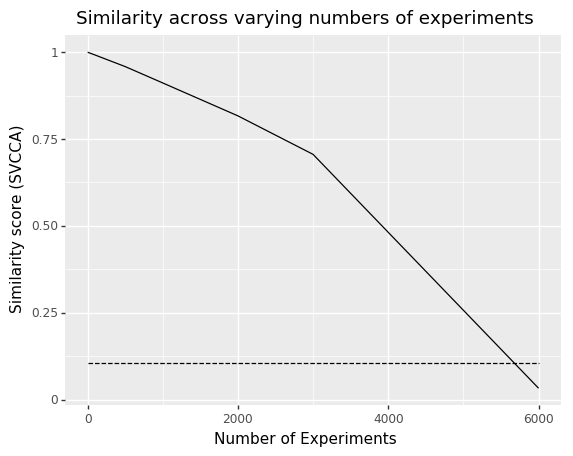

<ggplot: (-9223363295516253159)>


In [13]:
# Plot
threshold = pd.DataFrame(
    pd.np.tile(
        permuted_score,
        (len(lst_num_experiments), 1)),
    index=lst_num_experiments,
    columns=['score'])

g = ggplot(similarity_score_df, aes(x=lst_num_experiments, y='score')) \
    + geom_line() \
    + geom_line(aes(x=lst_num_experiments, y='score'), threshold, linetype='dashed') \
    + xlab('Number of Experiments') \
    + ylab('Similarity score (SVCCA)') \
    + ggtitle('Similarity across varying numbers of experiments')

print(g)
ggsave(plot=g, filename=svcca_file, dpi=300)